In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
import os
dir_module = os.getcwd()
sys.path.append(dir_module)
import panel_struct as ps # Module définissant les profils NACA et l'objet Panel
import elementary_flows as ef

On définit un objet correspondant à notre profil NACA 2412 de corde 1 m.

In [3]:
chord = 1.
naca_number = '2412'
airfoil = ps.NACA_Airfoil(naca_number,chord)

On définit notre discrétisation axiale selon une distribution circulaire, pour avoir plus de points autour du bord d'attaque et du bord de fuite. C'est la transformée de Glauert que l'on applique à une distribution uniforme d'angle. 
NB: On choisit un nombre de points impairs pour avoir le bord d'attaque (point d'arrêt) comme l'extrémité de deux panneaux.

In [4]:
npts = 51
x = chord / 2. * (1. - np.cos(np.linspace(0.,np.pi,npts)))

On calcule la forme du profil en utilisant la fonction `profile_side_shape` sur l'instance `airfoil`définit précédemment. On peut vérifier les arguments d'entrée et de sortie avec `help`.

In [5]:
help(airfoil.profile_side_shape)

Help on method profile_side_shape in module panel_struct:

profile_side_shape(x) method of panel_struct.NACA_Airfoil instance
    Compute the suction side of NACA 4 digits
    
    Parameters
    ----------
    x: coordinates along the chord
    
    Returns
    -------
    xU: coordinates along the x-axis of the upper edge of the profile
    yU: coordinates along the y-axis of the upper edge of the profile
    xL: coordinates along the x-axis of the lower edge of the profile
    yL: coordinates along the y-axis of the lower edge of the profile



In [6]:
xU,yU,xL,yL = airfoil.profile_side_shape(x)

Traçons le profil pour voir sa forme.

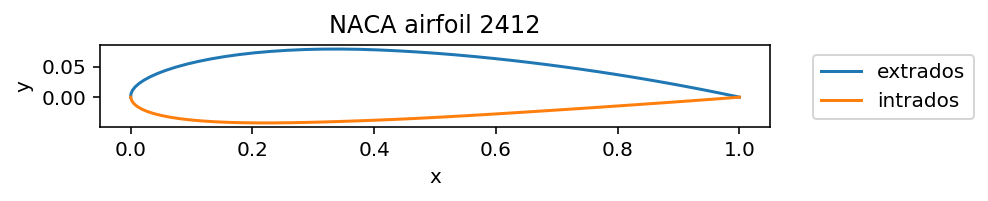

In [7]:
plt.plot(xU,yU,label='extrados');
plt.plot(xL,yL,label='intrados');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.05, 1));
plt.title('NACA airfoil {0:s}'.format(naca_number))
plt.axis('image');

On définit l'écoulement uniforme. La classe `Uniform` a été améliorée pour prendre en compte une incidence. On choisit une vitesse $V_\infty=1$ m/s et une incidence nulle pour commencer.

In [8]:
help(ef.Uniform.__init__)

Help on function __init__ in module elementary_flows:

__init__(self, Vinf, aoa=0.0)
    Sets the velocity at infinity and the angle of attack.
    
    Parameters
    ----------
    Vinf: float
        Velocity magnitude of the uniform flow
    aoa : float
        Angle of attack of the flow in degree (default 0.)



In [9]:
Vinf = 1.
incidence = 5.
uniform_flow = ef.Uniform(Vinf,incidence)

On va utiliser la classe `Panel` pour définir nos panneaux entre les points définis précédemment sur le profil.

In [10]:
help(ps.Panel.__init__)

Help on function __init__ in module panel_struct:

__init__(self, x1, y1, x2, y2)
    Sets the panel bound points and compute the panel center and length.
    
    Parameters
    ----------
    x1, y1 : coordinate of the first end point
    x2, y2 : coordinate of the second end point



Pour chaque panneau il faut donc définit ses extrémités. On évite les points répétés (en ignorant le premier indice de xU et yU). On va balayer le profil du bord de fuite, au bord d'attaque par l'intrados, puis retourner au bord de fuite par l'extrados. C'est une convention usuelle de la méthode des panneaux.

In [11]:
x_ends = np.concatenate((xL[::-1],xU[1:]))
y_ends = np.concatenate((yL[::-1],yU[1:]))
nb_panels = y_ends.size - 1
print('Nb panels = ',nb_panels)

Nb panels =  100


On crée un tableau qui va contenir les instances de la classe `Panel` pour chaque panneau.

In [12]:
panels = np.empty((nb_panels,),dtype='object')
for i in range(nb_panels):
    panels[i]=ps.Panel(x_ends[i],y_ends[i],x_ends[i+1],y_ends[i+1])
    #print('alpha = ',panels[i].alpha,'beta = ',panels[i].beta,'alpha + pi/2 = ',panels[i].alpha+np.pi/2)

In [13]:
xc_panels = [panel.xc for panel in panels]
yc_panels = [panel.yc for panel in panels]

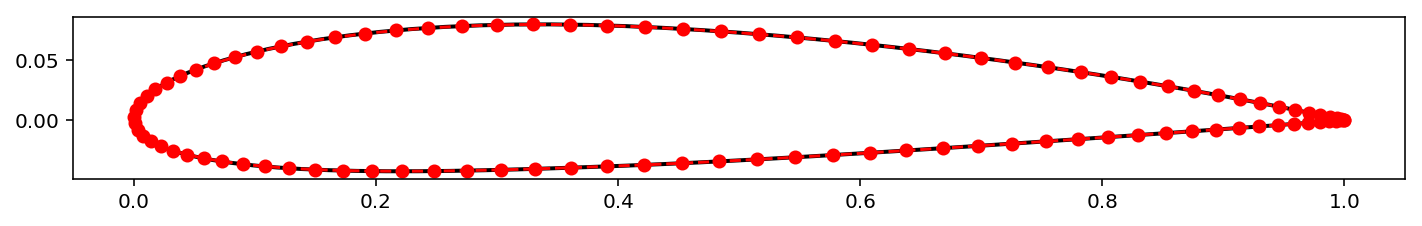

In [14]:
plt.figure(figsize=(10,8))
plt.plot(xU,yU,label='extrados',linewidth=2.0,color='black');
plt.plot(xL,yL,label='intrados',linewidth=2.0,color='black');
plt.plot(xc_panels,yc_panels,marker='o',color='red',linestyle='dashed')
plt.axis('image');
plt.tight_layout();
plt.savefig('discretisation_panels.png',dpi=120)

On va définir sur chaque panneau une source distribuée de débit linéique d'intensité constante $\lambda_j$ et un tourbillon distribué de circulation constante $\gamma$ identique sur tous les panneaux. Il faut déterminer la valeur de l'intensité pour chacune des sources et de la circulation. On appelle `sigma` dans le code, car `lambda` a une signification en python. 

On souhaite que chaque panneau corresponde à une ligne de courant de sorte à avoir un écoulement autour de notre profil. Le champs de vitesse construit comme la superposition des sources distribuées, des tourbillons distribués et de l'écoulement uniforme doit donc respecter la condition de glissement sur chaque panneau. De plus, on doit assurer la condition de Kutta que l'on exprime comme la vitesse tangentielle identique sur le premier et dernier panneau. Cela nous donne un système d'équations que l'on peut résoudre sous forme matricielle. 

On construit donc cette matrice et le terme de droite de l'équation $M\cdot X = B$ où $X$ est le vecteur formé des intensités des sources de chaque panneau. On utilise les fonctions `source_influence_analytic` et `vortex_influence_analytic` pour calculer les termes dits d'influence entre deux panneaux distincts, et on se souvient de la valeur singulière de la vitesse sur la source distribuée lorsque l'on calcule l'influence d'une source sur elle même. Pour chaque panneau, on connait son centre $(x_c,y_c)$ qui sera le point de contrôle du panneau. Et on connait également l'angle $\beta$ entre la normale du panneau et l'axe $(Ox)$ qui sert à exprimer la condition de glissement.

Le terme de droite du système d'équation correspond à la projection de la vitesse de l'écoulement uniforme sur le panneau.

On utilise la fonction `enumerate` pour boucler sur notre tableau de panneaux et avoir l'indice correspondant par la même occasion.

In [15]:
# Initialisation
M_influence = np.empty((nb_panels+1,nb_panels+1))
S_influence = np.empty((nb_panels,nb_panels))
V_influence = np.empty((nb_panels,nb_panels))
RHS = np.zeros((nb_panels+1,1))

# Détermination de la matrice d'influence pour les sources
for i,panel_i in enumerate(panels):
    for j,panel_j in enumerate(panels):
        if i==j:
            S_influence[i,j] = 0.5
        else:
            S_influence[i,j] = \
                panel_j.source_influence_analytic(panel_i.xc,panel_i.yc,panel_i.beta)

# Détermination de la matrice d'influence pour les tourbillons
for i,panel_i in enumerate(panels):
    for j,panel_j in enumerate(panels):
        if i==j:
            V_influence[i,j] = 0.0
        else:
            V_influence[i,j] = \
                panel_j.vortex_influence_analytic(panel_i.xc,panel_i.yc,panel_i.beta)

# Construction de la matrice d'influence 
M_influence[:-1,:-1] = S_influence
M_influence[:-1,-1] = np.sum(V_influence,axis=1)
M_influence[-1,:-1] = - (V_influence[0,:]+V_influence[-1,:])
M_influence[-1,-1] = np.sum(S_influence[0,:]+S_influence[-1,:])

# Construction du terme de droite
for i,panel_i in enumerate(panels):
    RHS[i] = - uniform_flow.Vinf * np.cos( uniform_flow.aoa - panel_i.beta )
RHS[-1] = uniform_flow.Vinf * (np.sin( uniform_flow.aoa - panels[0].beta )+np.sin( uniform_flow.aoa - panels[-1].beta ))

On calcule donc l'intensité des sources et la circulation des tourbillons en résolvant le problème matriciel $M\cdot X=B$. On utilise le module `linalg` de `numpy` et notamment la fonction `solve`.

In [16]:
X_panels = np.linalg.solve(M_influence,RHS)
#plt.plot(X_panels)

On vérifie que la forme est bien fermée en s'assurant que la somme des intensités des sources est nulle. Sinon il y aurait un débit de fluide happé ou injecté par les panneaux dans l'écoulement, tandis qu'on ne souhaite que créer le blocage. 

In [17]:
accuracy = 0.
for i,panel_i in enumerate(panels):
    accuracy += panel_i.length * X_panels[i,0]
print('--> sum of source/sink strengths: {0:f}'.format(accuracy))

--> sum of source/sink strengths: 0.001082


On peut maintenant ajouter à chaque panneau la valeur du débit distribué calculé. Et calculer le champ de vitesse en applicant le principe de superposition. On définit une grille de calcul sur le domaine $[-1,2]\times[-0.5,0.5]$ avec 200 points dans chaque direction.

In [18]:
dom_npts = 100
x = np.linspace(-1.,2.,dom_npts)
y = np.linspace(-0.5,0.5,dom_npts)
X,Y = np.meshgrid(x,y)

Short domain is a restriction of previous one with increased resolution

In [19]:
x_short = np.linspace(0.8,1.2,dom_npts)
y_short = np.linspace(-0.1,0.1,dom_npts)
Xs,Ys = np.meshgrid(x_short,y_short)

On calcule le champ de vitesse uniforme sur cette grille

In [20]:
uniform_flow.compute_fields(X,Y)
U = uniform_flow.u.copy()
V = uniform_flow.v.copy()

On applique le principe de superposition.

In [21]:
for i,panel_i in enumerate(panels):
    panel_i.source_strength = X_panels[i]
    panel_i.vortex_strength = X_panels[-1]
    panel_i.compute_source_analytic(X,Y)
    panel_i.compute_vortex_analytic(X,Y)
    U += panel_i.source.u + panel_i.vortex.u
    V += panel_i.source.v + panel_i.vortex.v

On peut regarder l'écoulement. On utilise également Bernoulli (formulation forte) pour calculer le champ de coefficient de pression. (Oui on a les hypothèses qui vont bien).

In [22]:
Vmag = np.sqrt(U**2 + V**2)
Cp = 1. - Vmag**2/Vinf**2

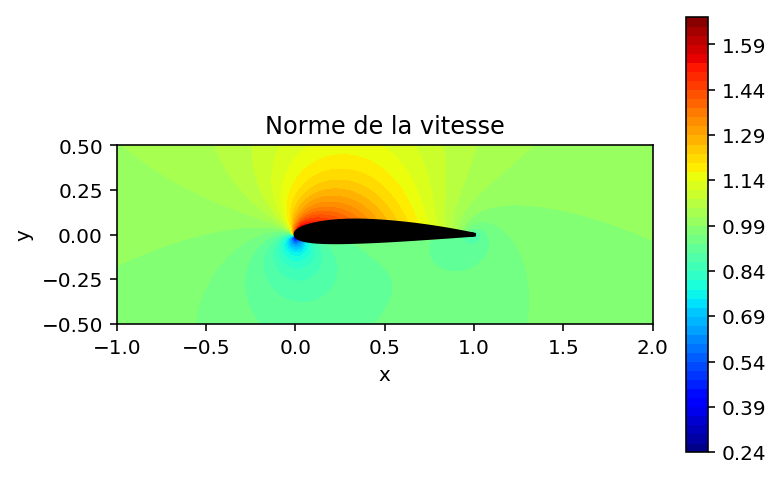

In [23]:
plt.fill(xc_panels,yc_panels,color='k', linestyle='solid', linewidth=2, zorder=2)
plt.contourf(X,Y,Vmag,50,cmap='jet');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Norme de la vitesse');
plt.axis('image');
plt.colorbar();

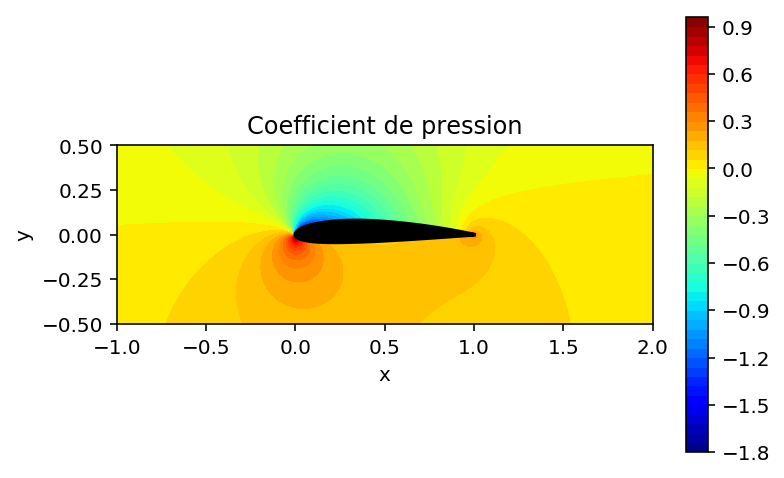

In [24]:
plt.fill(xc_panels,yc_panels,color='k', linestyle='solid', linewidth=2, zorder=2)
plt.contourf(X,Y,Cp,50,cmap='jet');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Coefficient de pression');
plt.axis('image');
plt.colorbar();

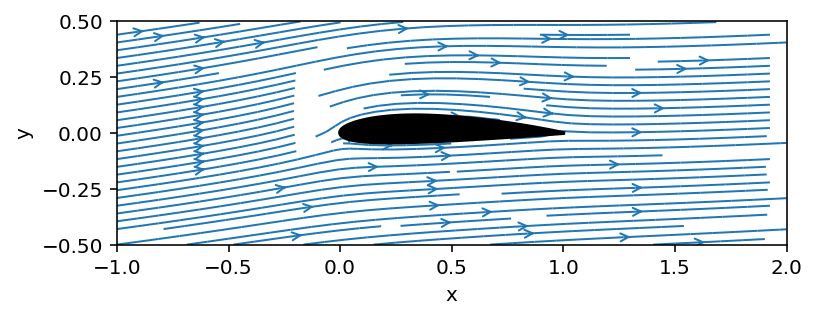

In [25]:
plt.streamplot(x, y, U, V, linewidth=1, arrowsize=1, arrowstyle='->',density=1)
plt.fill(xc_panels,yc_panels,color='k', linestyle='solid', linewidth=2, zorder=2)
plt.xlabel('x');
plt.ylabel('y');
plt.axis('image');

In [26]:
uniform_flow.compute_fields(Xs,Ys)
Us = uniform_flow.u.copy()
Vs = uniform_flow.v.copy()

On applique le principe de superposition.

In [27]:
for i,panel_i in enumerate(panels):
    panel_i.source_strength = X_panels[i]
    panel_i.vortex_strength = X_panels[-1]
    panel_i.compute_source_analytic(Xs,Ys)
    panel_i.compute_vortex_analytic(Xs,Ys)
    Us += panel_i.source.u + panel_i.vortex.u
    Vs += panel_i.source.v + panel_i.vortex.v

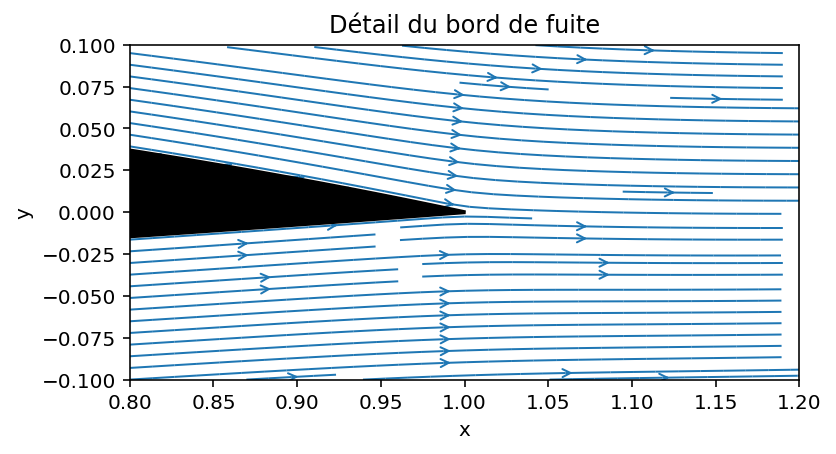

In [28]:
plt.streamplot(x_short, y_short, Us, Vs, linewidth=1, arrowsize=1, arrowstyle='->',density=1)
plt.fill(xc_panels,yc_panels,color='k', linestyle='solid', linewidth=2, zorder=2)
plt.xlabel('x');
plt.ylabel('y');
plt.axis('image');
plt.title('Détail du bord de fuite');
plt.xlim(0.8,1.2);
plt.ylim(-0.1,0.1);

Pour calculer le coefficient de pression sur le profil, on souhaite calculer la vitesse de glissement sur chaque panneau et utiliser à nouveau Bernoulli. On peut utiliser une expression analytique pour calculer la vitesse tangentielle au panneau plutôt que d'essayer de calculer le champ directement. C'est plus robuste.  

In [29]:
# Initialisation
M_influence_P = np.empty((nb_panels,nb_panels+1))
S_influence_P = np.empty((nb_panels,nb_panels))
V_influence_P = np.empty((nb_panels,nb_panels))
RHS_P = np.zeros((nb_panels,1))

# Détermination de la matrice d'influence pour les sources
for i,panel_i in enumerate(panels):
    for j,panel_j in enumerate(panels):
        if i==j:
            S_influence_P[i,j] = 0.0
        else:
            S_influence_P[i,j] = \
                panel_j.source_influence_analytic(panel_i.xc,panel_i.yc,panel_i.alpha)

# Détermination de la matrice d'influence pour les tourbillons
for i,panel_i in enumerate(panels):
    for j,panel_j in enumerate(panels):
        if i==j:
            V_influence_P[i,j] = 0.5
        else:
            V_influence_P[i,j] = \
                panel_j.vortex_influence_analytic(panel_i.xc,panel_i.yc,panel_i.alpha)

# Construction de la matrice d'influence 
M_influence_P[:,:-1] = S_influence_P
M_influence_P[:,-1] = np.sum(V_influence_P,axis=1)

# Construction du terme de droite
for i,panel_i in enumerate(panels):
    RHS_P[i] = - uniform_flow.Vinf * np.cos( uniform_flow.aoa - panel_i.alpha )

In [30]:
Vt = np.dot(M_influence_P,X_panels) - RHS_P
Cp_panels = 1 - Vt**2 / Vinf**2

In [31]:
data_xfoil = np.loadtxt('XFOIL_IVISC/CP_NACA2412_XFOIL_IVISC_ALFA_{0:.1f}.TXT'.format(incidence),skiprows=1)

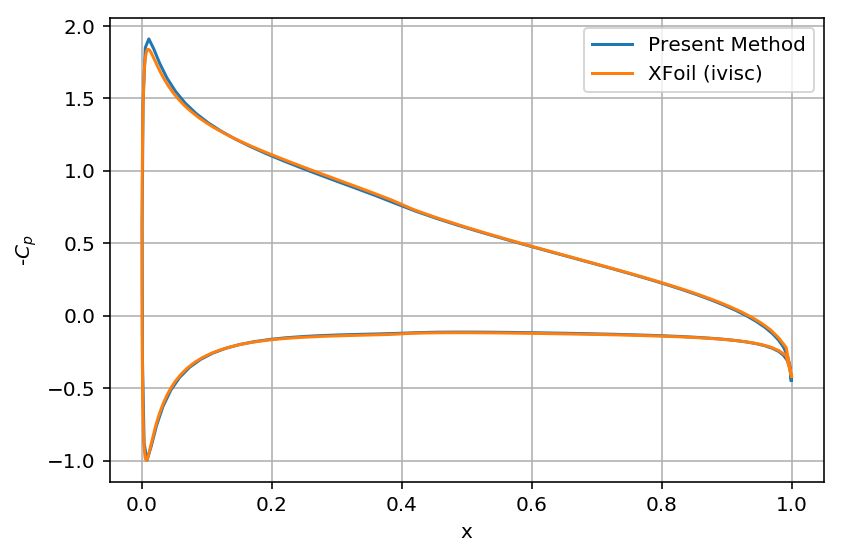

In [32]:
plt.plot(xc_panels,-Cp_panels,label='Present Method');
plt.plot(data_xfoil[:,0],-data_xfoil[:,1],label='XFoil (ivisc)');
plt.xlabel('x');
plt.ylabel(r'-$C_p$');
plt.legend();
plt.grid();
plt.tight_layout();
plt.savefig('CP_panels_NACA2412_ALFA_{0:.1f}.png'.format(incidence),dpi=120)